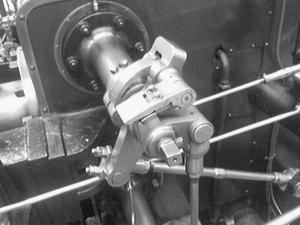

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from PIL import Image

image = Image.open('data/valve.png').convert('LA')
image

Convert to a numpy array, convert to float32, and expand to be 4D `(batch_size, height, width, channel)`.


In [6]:
mat = np.array(image)[..., :1]
mat = mat.astype(np.float32)
mat = mat[np.newaxis]
mat.shape

(1, 225, 300, 1)

## Convolution Operator

This example shows how the convolution operator works in Tensorflow. Here we're hard coding the kernel to the Sobel operator, which can be used to highlight edges in an image. Normally, we would learn the values of the kernel via backpropagation instead of hand coding them directly. 

In [13]:
def sobel_kernel(shape, dtype):
    """Initialise the kernel to the Sobel horizontal operator"""
    
    kernel = np.array([
      [+1, 0, -1],
      [+2, 0, -2],
      [+1, 0, -1],
    ])

    return kernel.reshape(shape)
  
conv_layer = tf.keras.layers.Conv2D(filters=1, kernel_size=3, strides=1, padding='same', dilation_rate=1, 
                                    kernel_initializer=sobel_kernel)
out = conv_layer(mat)  # Apply conv layer to image

out = np.squeeze(out)  # Get rid of the first and last dimensions
out = np.absolute(out) # Convert response to magnitude
out = np.uint8(out)    # Convert to int for visualisation
out.shape

(225, 300)

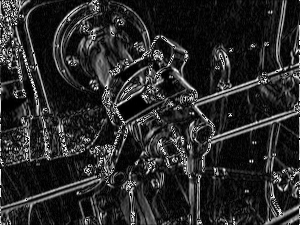

In [14]:
Image.fromarray(out)

## MaxPooling Operator

The max pooling operator takes an input and chooses the maximum of each non-overlapping patch as the value for the next image. This essentially results in a crude downsampling of the whole image.

In [15]:
max_pool_layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2))
out = max_pool_layer(mat)

out = np.squeeze(out)
out = np.uint8(out)
out.shape

(112, 150)

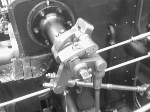

In [16]:
Image.fromarray(out)

## Upsampling2D

This will just use simple nearesy neighbour interpolation to upsample the image by a given factor.

In [20]:
conv_trans_layer = tf.keras.layers.UpSampling2D(size=(2, 2), interpolation='nearest')
out_trans = conv_trans_layer(mat)

out_trans = np.squeeze(out_trans)
out_trans = np.uint8(out_trans)
out_trans.shape

(450, 600)

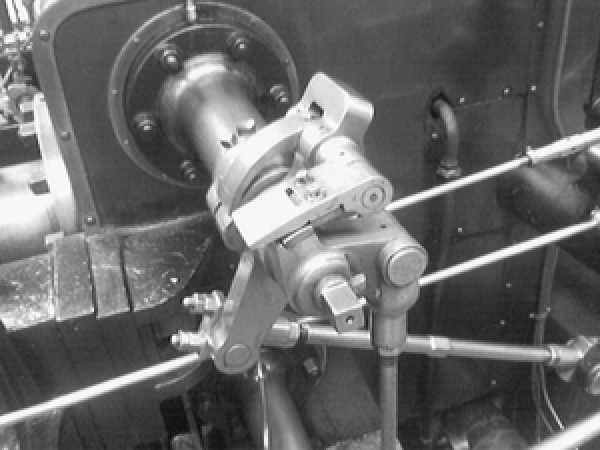

In [21]:
Image.fromarray(out_trans)

## Transpose Convolution

In [22]:
img = out[np.newaxis, :, :, np.newaxis]
img = img.astype(np.float32)

def gaussian_kernel(shape, dtype):
    """Initialise the kernel to the Gaussian matrix"""
    nsig = 1
    kernlen = shape[0]
    x = np.linspace(-nsig, nsig, kernlen+1)
    kern1d = np.diff(st.norm.cdf(x))
    kern2d = np.outer(kern1d, kern1d)
    kernel = kern2d/kern2d.sum()
    return kernel.reshape(shape)

conv_trans_layer = tf.keras.layers.Conv2DTranspose(kernel_size=4, strides=2, filters=1, kernel_initializer=gaussian_kernel)
out_trans = conv_trans_layer(img)

out_trans = np.squeeze(out_trans)
# Normalise the outputs back to the 0-255 range
out_trans = (out_trans - out_trans.min()) / (out_trans.max() - out_trans.min()) * 255
out_trans = np.uint8(out_trans)
out_trans.shape

(226, 302)

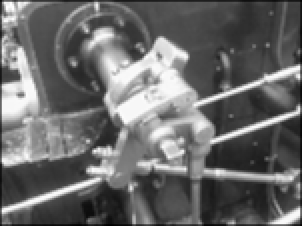

In [23]:
Image.fromarray(out_trans)